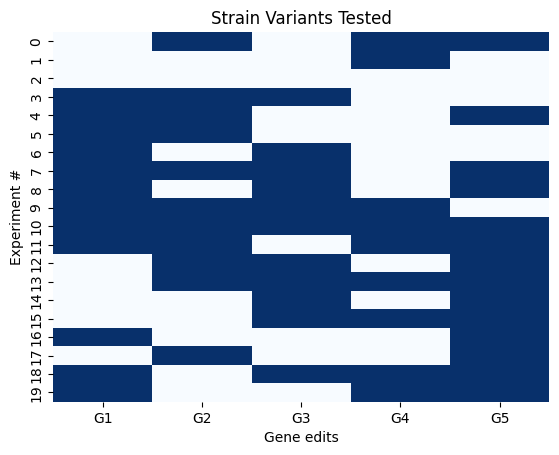

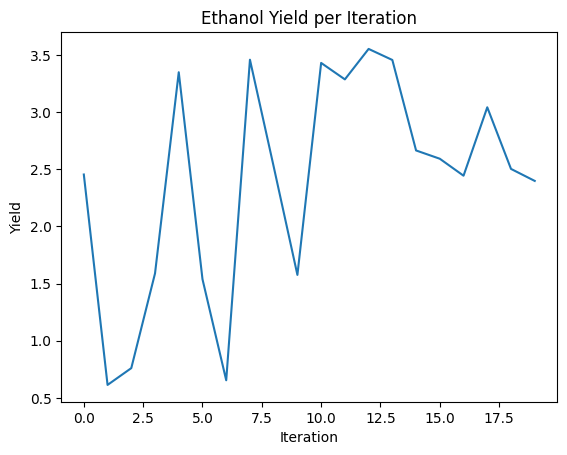

In [3]:
# GP Bayesian Optimization for Strain Variants (Binary Gene Edits)

import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from botorch.sampling import SobolQMCNormalSampler

# Simulated mapping from strain genotype (binary edits) to kinetic parameters
# Assume 5 genes, each gene affects Vmax1 or Vmax2 in nonlinear way
def strain_to_yield(strain):
    # Map 5 binary genes to E1 and E2 (Vmax-like)
    E1 = 1.0 + 2.0 * strain[0] + 1.5 * strain[2] - 0.5 * strain[3]
    E2 = 1.0 + 1.0 * strain[1] + 2.0 * strain[4] - 0.3 * strain[0]

    # Simulate ethanol yield (simple model for demo)
    Km1, Km2 = 0.5, 0.3
    glucose = 10.0
    v1 = (E1 * glucose) / (Km1 + glucose)
    v2 = (E2 * v1) / (Km2 + v1)
    return v2  # Final ethanol approximation

# Create binary design space of 5 genes
gene_count = 5
all_variants = torch.tensor(list(product([0,1], repeat=gene_count)), dtype=torch.double)

# Select initial random samples
init_idx = torch.randperm(len(all_variants))[:10]
train_X = all_variants[init_idx]
train_Y = torch.tensor([[strain_to_yield(x)] for x in train_X], dtype=torch.double)

# Fit GP
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# BO loop
for iteration in range(10):
    model.eval()
    # Get unexplored candidates
    remaining = [i for i in range(len(all_variants)) if i not in init_idx]
    candidate_X = all_variants[remaining]

    # Compute acquisition function
    acq = qLogExpectedImprovement(model=model, best_f=train_Y.max(), sampler=None)

    # Add q-batch dimension correctly
    with torch.no_grad():
        acq_vals = acq(candidate_X.unsqueeze(1))  #[N, 1, d]
    
    best_idx = torch.argmax(acq_vals)
    new_X = candidate_X[best_idx].unsqueeze(0)
    new_Y = torch.tensor([[strain_to_yield(new_X[0])]], dtype=torch.double)

    # Update data
    train_X = torch.cat([train_X, new_X])
    train_Y = torch.cat([train_Y, new_Y])
    init_idx = torch.cat([init_idx, torch.tensor([remaining[best_idx]])])

    # Update model
    model.set_train_data(train_X, train_Y.squeeze(-1), strict=False)
    fit_gpytorch_mll(mll)

# Plot
import seaborn as sns
sns.heatmap(train_X.numpy(), cmap='Blues', cbar=False, xticklabels=[f'G{i+1}' for i in range(gene_count)])
plt.title("Strain Variants Tested")
plt.xlabel("Gene edits")
plt.ylabel("Experiment #")
plt.show()

plt.plot(train_Y.numpy())
plt.title("Ethanol Yield per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Yield")
plt.show()
